# Notebook Index:

1. [Import Libraries](#import_libraries)
2. [Load Data](#load_data)
3. [Data Cleaning](#data_cleaning)
4. [Feature Engineering](#feature_engineering)
5. [Exploratory Analysis](#exploratory_analysis)
6. [Model Building](#model_building)
7. [Model Evaluation](#model_evaluation)

### 1. Import Libraries <a id="import_libraries"></a>
In this section we import the libraries used in this notebook.   

In [1]:
#Import Libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb

We also set up the formatting for the charts produced throughout the analysis.

In [2]:
#Ignore warnings
warnings.filterwarnings('ignore')

# Create fontdicts for formatting figure text
axtitle_dict = {'family': 'serif','color':  'darkred','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

### 2. Load Data <a id="load_data"></a>
The data in this notebook can be downloaded from the [Taxi & Limousine Commission](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) section of the NYC government website.   
For the purpose of this work, the months of March, June and November of 2017 were downloaded to the project folder.


In [3]:
#Locate and load data to a single dataframe
folder_path = os.path.join(os.getcwd(), "data","raw")
file_names=['yellow_tripdata_2017-03.parquet','yellow_tripdata_2017-06.parquet','yellow_tripdata_2017-11.parquet']
dfs = [pd.read_parquet(os.path.join(folder_path, file_name), engine='pyarrow') for file_name in file_names]
df = pd.concat(dfs, ignore_index=True)

### 3. Data Cleaning <a id="data_cleaning"></a>
In this section, we do some basic exploration of the data and we exclude or mark as invalid the values that fall outside of sensible ranges.

In [4]:
#Let´s limit the dates to the expected years and months
df = df[df["tpep_pickup_datetime"].dt.year.isin([2017]) & df["tpep_dropoff_datetime"].dt.month.isin([3, 6, 11])]

In [5]:
#Number of rows and columns
df.shape

(29224099, 19)

In [6]:
#Data types by field
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29224099 entries, 0 to 29237236
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   object        
 18  airport_fee         

In [7]:
#Show a few rows.
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2017-03-01 00:38:16,2017-03-01 00:59:21,1,10.5,1,N,231,42,1,30.5,0.5,0.5,6.00,0.0,0.3,37.80,None,None
1,1,2017-03-01 00:25:01,2017-03-01 00:31:36,1,1.4,1,N,239,262,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,None,None
2,1,2017-03-01 00:43:48,2017-03-01 00:44:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,None,None
3,1,2017-03-01 00:47:17,2017-03-01 00:47:33,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,None,None
4,1,2017-03-01 00:13:37,2017-03-01 00:13:46,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,None,None


In [8]:
#Show minimum and maximum values by field
df.agg(['min','max'])

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
min,1,2017-03-01 00:00:00,2017-03-01 00:00:00,0,0.00,1,N,1,1,1,-550.00,-53.71,-0.5,-112.0,-17.50,-0.3,-550.30,NaN,NaN
max,2,2017-11-30 23:59:05,2017-11-30 23:59:59,192,9496.98,99,Y,265,265,5,630461.82,69.80,140.0,450.0,1018.95,1.0,630463.12,NaN,NaN


In [9]:
#Replace with NaN those values that do not lie within a sensible range.
df['passenger_count'].mask(df['passenger_count'].between(1, 5)==False, inplace=True)
df['trip_distance'].mask(df['trip_distance'].between(0.01, 100)==False, inplace=True)
df['fare_amount'].mask(df['fare_amount']<=0, inplace=True)
df['extra'].mask(df['extra']<0, inplace=True)
df['RatecodeID'].mask(df['RatecodeID'].between(1, 6)==False, inplace=True)
df['total_amount'].mask(df['total_amount'].between(0.01, 800)==False, inplace=True)
df['improvement_surcharge'].mask(df['improvement_surcharge']<0, inplace=True)
df['tip_amount'].mask(df['tip_amount']<=0, inplace=True)

### 4. Feature Engineering <a id="feature_engineering"></a>

In order to generate a model with good predictive power, this sections aims to transform and create a series of features that could potentially have an impact on the tip amount. Their predicitve value will be analysed afterwards.

In [10]:
#Let´s infer the trip duration in hours based on the dropoff and the pickup times.
df["trip_duration_hours"]= (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]) / np.timedelta64(1, "h")

#Let´s divide the datetimes in their timeframe constituents.
df["tpep_pickup_hour"]=df["tpep_pickup_datetime"].dt.hour
df["tpep_pickup_day"]=df["tpep_pickup_datetime"].dt.day
df["tpep_pickup_month"]=df["tpep_pickup_datetime"].dt.month
df["tpep_pickup_weekday"]=df["tpep_pickup_datetime"].dt.weekday
df["tpep_dropoff_hour"]=df["tpep_dropoff_datetime"].dt.hour
df["tpep_dropoff_weekday"]=df["tpep_dropoff_datetime"].dt.weekday

#Let´s group in weekday or weekend journeys
df['pickup_is_weekend'] = np.where(df['tpep_pickup_weekday'] >= 5, 1, 0)
df['dropoff_is_weekend'] = np.where(df['tpep_dropoff_weekday'] >= 5, 1, 0)

#Let´s group the hour of the pickup and dropoff in three time intervals of the day (0-7: Morning; 8-15: Core Hours; 16-23: Evening and Night )
def time_of_day(tpep_dropoff_hour):
    return 1 if 0 <= tpep_dropoff_hour < 8 else 2 if 8 <= tpep_dropoff_hour < 16 else 3
df['time_of_day_dropoff'] = df["tpep_dropoff_hour"].apply(time_of_day)
df['time_of_day_pickup'] = df["tpep_pickup_hour"].apply(time_of_day)

#New features relating variables: Fare amount & Duration, Fare amount and Distance; Distance & Duration.
df['fare_amount_to_duration_ratio'] = df['fare_amount'] / df['trip_duration_hours']
df['fare_amount_to_distance_ratio'] = df['fare_amount'] / df['trip_distance']
df['distance_to_duration_ratio'] = df['trip_distance'] / df['trip_duration_hours']

#The introduction of the previous fields produces some infinte values, that we will convert to invalid values.
df=df.replace([np.inf, -np.inf], np.nan)

The new or the given features are not necessarily useful.   
As a first filter, we will exclude those fields that present a high percentage of information missing.  
We will also exclude those rows of the tip amount with no information.


In [11]:
#Percentage of invalid data by field
per_nulls= df.isnull().sum()*100/len(df)
df_per_nulls = pd.DataFrame(per_nulls, columns=['percentage_missing'])
df_per_nulls[df_per_nulls["percentage_missing"]!=0.0].sort_values(by="percentage_missing", ascending=False)

,percentage_missing
congestion_surcharge,100.000000
airport_fee,100.000000
tip_amount,34.966799
passenger_count,3.088301
fare_amount_to_distance_ratio,0.709719
distance_to_duration_ratio,0.658265
trip_distance,0.655476
fare_amount_to_duration_ratio,0.169295
fare_amount,0.078302
total_amount,0.061316


In [12]:
#Remove unusable columns and invalid rows based on the percentage of invalid data
df.drop(["congestion_surcharge", "airport_fee"], axis=1, inplace=True)
df=df.dropna()

### 5. Exploratory Analysis <a id="exploratory_analysis"></a>

In the search of insights that can inform the model selection, let´s explore:  
- The distributions by field
- The corrrelation of each variable with the the tip amount
- The correlations between pairs of fields
- Excluding fields with no impact on the tip amount.

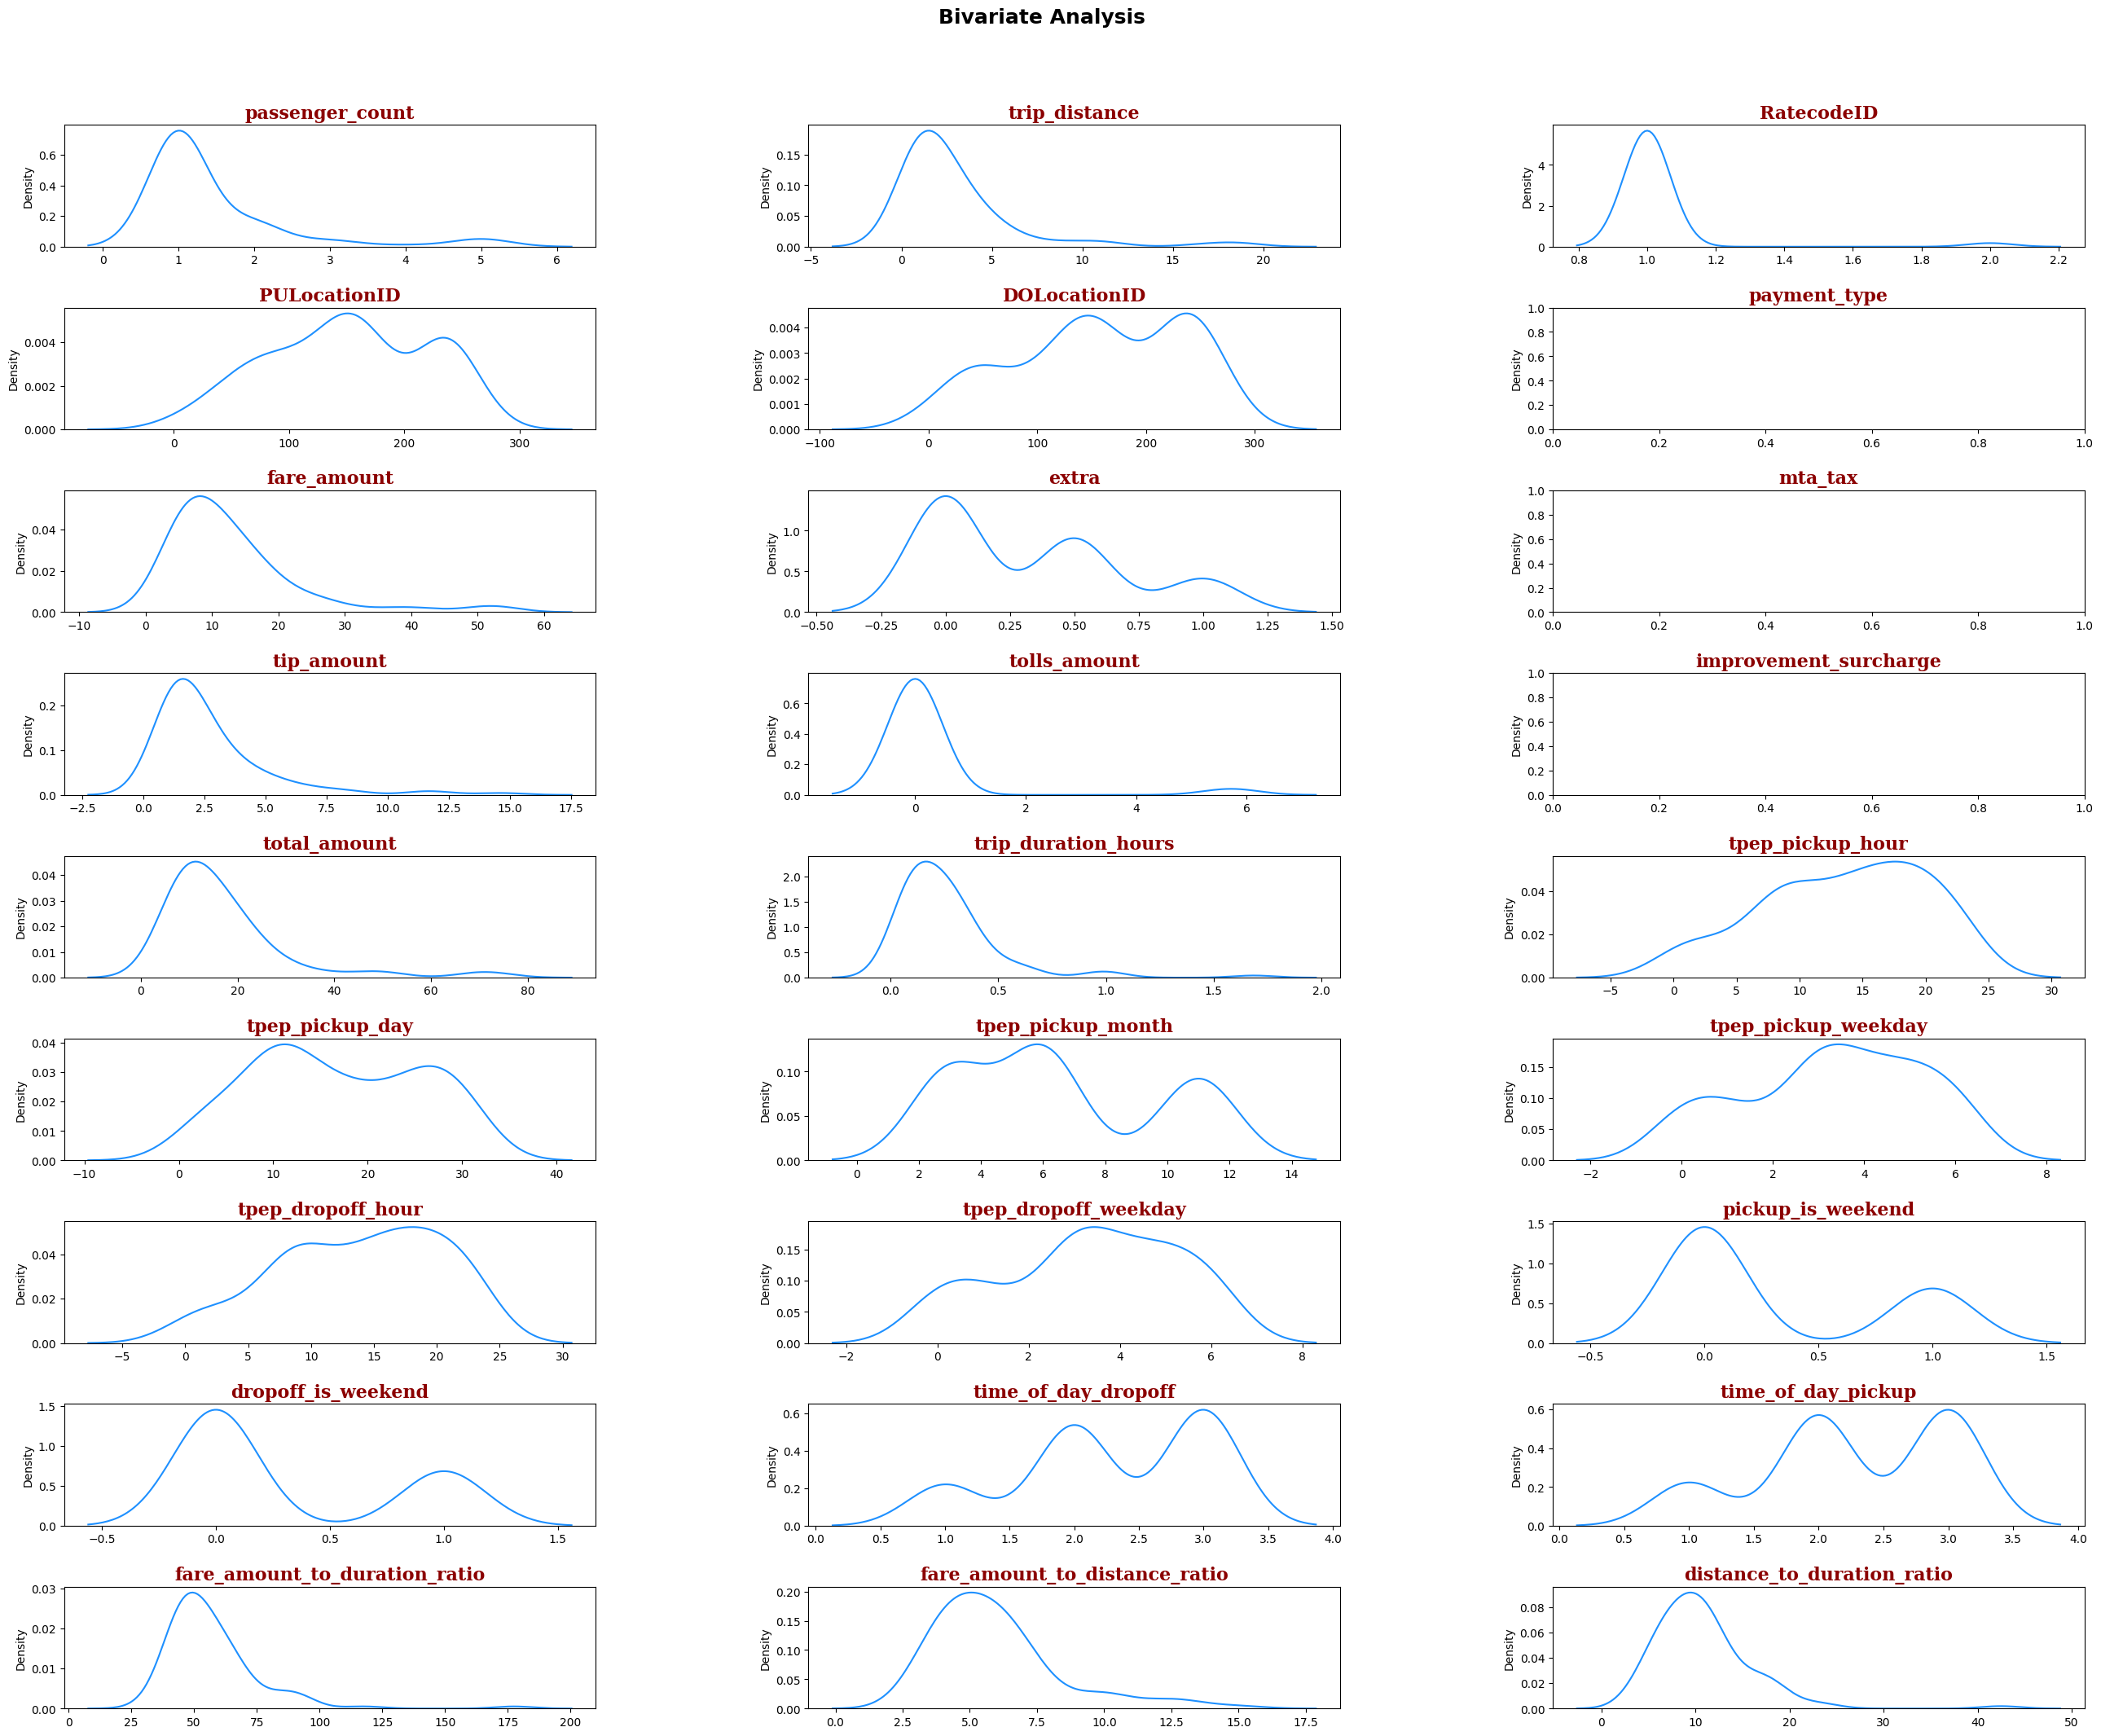

In [13]:
# Sample data at random
dfr=df.sample(frac=1) 

#Exclude fields from plots
exclude_cols=["VendorID","tpep_pickup_datetime","tpep_dropoff_datetime","store_and_fwd_flag","pickup_year","pickup_month"]
Num_cols=[x for x in dfr.columns.to_list() if x not in exclude_cols]

#Generate charts
fig = plt.figure(figsize=[32,24]) 
fig.suptitle('Bivariate Analysis', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(Num_cols):
    a = fig.add_subplot(9, 3, i+1)   
    sns.distplot(x =dfr[col].head(100),  color='dodgerblue' , ax=a ,  hist =False)
    a.set_title(col , fontdict=axtitle_dict)    

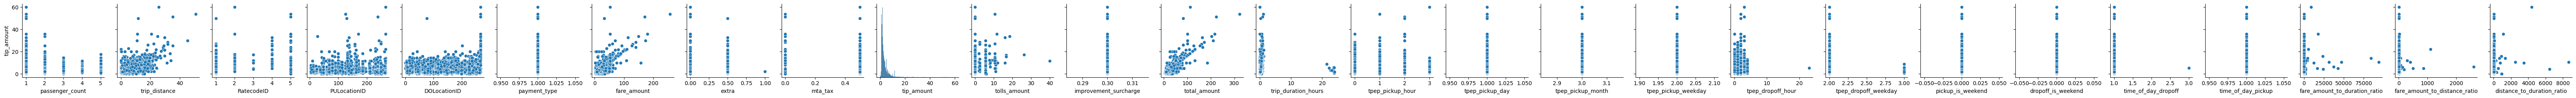

In [14]:
#Let's see the scatter plots for the tip amount against the other variables to visualize trends and correlations.
sns.pairplot(data=df[Num_cols].head(10000), y_vars="tip_amount" )

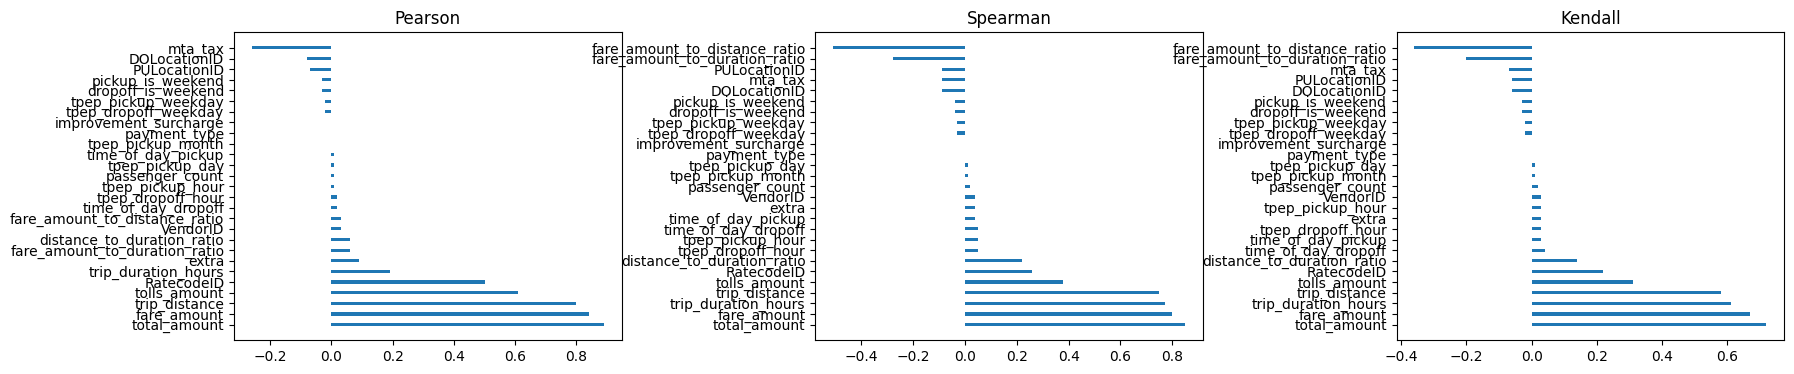

In [15]:
#Let's compute correlations by variable with the tip_amount
ax1 = round(df.corr(method="pearson")['tip_amount'].sort_values(ascending = False)[1:] ,2 )
ax2 = round(df.corr(method="spearman")['tip_amount'].sort_values(ascending = False)[1:] ,2 )
ax3 = round(df.corr(method="kendall")['tip_amount'].sort_values(ascending = False)[1:] ,2 )

#Plot them
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].barh(ax1.index, ax1.values, height=0.3)
axs[0].set_title('Pearson') #Pearson
axs[1].barh(ax2.index, ax2.values, height=0.3)
axs[1].set_title('Spearman') #Spearman
axs[2].barh(ax3.index, ax3.values,height=0.3)
axs[2].set_title('Kendall') #Kendall

#Adjust space between charts
plt.subplots_adjust(wspace=0.5)

# Show the figure
plt.show()

In [28]:
# Note there are a few pairs of fields highly correlated between them (>0.9)
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                print("Pearson correlation of "+ str(corr.iloc[i,j])[:4]+" detected between:'"+ str(corr.columns[i])+"' and '"+str(corr.columns[j])+"'")

Pearson correlation of 0.94 detected between:'trip_distance' and 'fare_amount'
Pearson correlation of 0.93 detected between:'trip_distance' and 'total_amount'
Pearson correlation of 0.98 detected between:'fare_amount' and 'total_amount'
Pearson correlation of 0.93 detected between:'tpep_pickup_hour' and 'tpep_dropoff_hour'
Pearson correlation of 0.92 detected between:'tpep_pickup_hour' and 'time_of_day_pickup'
Pearson correlation of 0.99 detected between:'tpep_pickup_weekday' and 'tpep_dropoff_weekday'
Pearson correlation of 0.93 detected between:'tpep_dropoff_hour' and 'time_of_day_dropoff'
Pearson correlation of 0.99 detected between:'pickup_is_weekend' and 'dropoff_is_weekend'
Pearson correlation of 0.94 detected between:'time_of_day_dropoff' and 'time_of_day_pickup'


In [17]:
# Feature Selection - Remove columns with no apparent impact on the tip amount.
df.drop(["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag","payment_type","improvement_surcharge"], axis=1, inplace=True)

In [18]:
#Save preprocessed data to staging folder
stg_data = os.path.join(os.getcwd(), "data","staging","stg_data.csv")
df.to_csv(stg_data,chunksize=1000) 

### 6. Model Building <a id="model_building"></a>

In this section:
- The preprocessed data produced in the previous steps is loaded in a new dataframe.
- The dataset is split into the training and the testing subsets.
- Various models are trained on the training set and their predictions for both the training and the testing splits are stored for further analysis.

In [19]:
#Load preprocessed data
stg_data = os.path.join(os.getcwd(), "data","staging","stg_data.csv")
df=pd.read_csv(stg_data)

In [20]:
#We first separate the dependent feature from the rest.
y=df[["tip_amount"]]
X=df.drop("tip_amount", axis=1)

#Finally, we slice the datasets in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=101)

##### Linear Regression
- The Linear Regression modesl is a simple yet powerful approach that assumes a linear relationship between input features and the target variable.
- It finds the best-fitting line by minimizing the sum of squared differences between the predicted and the actual values.
- It is widely used for predicting numeric outcomes due to its interpretability and ease of use.

In [21]:
#Let´s train a linear regression model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_train_linear_reg = linear_reg.predict(X_train)
y_pred_test_linear_reg = linear_reg.predict(X_test)

##### Ridge Regression
- Ridge Regression is a linear regression technique that adds L2 regularization to mitigate overfitting. It consists of introducing a penalty term based on the sum of squared coefficients, which helps stabilize the model.
- This model is effective in dealing with multicollinearity and improving the generalization of linear regression models.

In [22]:
ridge = Ridge().fit(X_train, y_train)
y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

##### Lasso Regression
- The Lasso Regression is a linear regression technique that incorporates L1 regularization to address overfitting.This consists of introducing a penalty term based on the sum of the absolute values of coefficients, encouraging feature selection by driving some coefficients to exactly zero.
- This model is particularly useful when dealing with high-dimensional data and aiming to simplify the model by automatically selecting a subset of relevant features.

In [23]:
lasso = Lasso().fit(X_train, y_train)
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

##### Elastic Net
- The Elastic Net model combines the strengths of Ridge and Lasso by using both L2 (Ridge) and L1 (Lasso) regularization techniques.
- It is valuable for feature selection and reducing multicollinearity in datasets with many features.

In [24]:
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=1000, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_train_elastic_net = elastic_net.predict(X_train)
y_pred_test_elastic_net = elastic_net.predict(X_test)

##### Decision Tree 
- The Decision Tree Regressor is a non-linear model that recursively splits data into subsets based on feature conditions to make predictions.
- It is capable of capturing complex relationships in the data but is prone to overfitting.

In [25]:
decision_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_train_decision_tree = decision_tree.predict(X_train)
y_pred_test_decision_tree = decision_tree.predict(X_test)

#### XGBoost
- The XGBoost, or Extreme Gradient Boosting model is a powerful ensemble method that combines multiple decision trees to create a robust predictive approach.
- It uses gradient boosting, an iterative optimization process, to improve model performance.
- XGBoost is known for its efficiency, scalability, and high predictive accuracy, making it a popular choice for various regression and classification tasks.

In [26]:
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_regressor.fit(X_train, y_train)
y_pred_train_xgb_regressor = xgb_regressor.predict(X_train)
y_pred_test_xgb_regressor= xgb_regressor.predict(X_test)

### 7. Model Evaluation <a id="model_evaluation"></a>

Some of the most common metrics to evaluate the performance of a regression model are the Mean Absolute Error (MAE), the Mean Squared Error (MSE), the Root Mean Squared Error (RMSE) and the R score. 
- The Mean Absolute Error (MAE) measures the average absolute differences between the predicted and actual values.A lower MAE indicates that the model's predictions are, on average, closer to the true values.
- The Mean Squared Error (MSE) measures the average squared differences between the predicted and the actual values. By squaring the errors, MSE penalizes larger errors more heavily, making it sensitive to outliers. 
- The Root Mean Squared Error (RMSE) is the square root of the MSE and provides a measure of the average magnitude of errors in the predicted values. It is in the same units as the dependent variable.
- The R-squared (R2) Score measures the proportion of the variance in the dependent variable explained by the model. It is a value between 0 and 1, with higher values indicating that the model explains a larger portion of the variance.

In this section we compare the peformance of the various models on the previous metrics. At the same time and in order to discard the possibility of overfitting, we show these metrics for predictions using the training and the test datasets alike.

In [27]:
model_y_preds=[
    ("Linear Regression", y_pred_train_linear_reg, y_pred_test_linear_reg),
    ("Lasso", y_pred_train_lasso, y_pred_test_lasso),
    ("Ridge", y_pred_train_ridge, y_pred_test_ridge),
    ("Elastic Net", y_pred_train_elastic_net, y_pred_test_elastic_net),
    ("Decision Tree", y_pred_train_decision_tree, y_pred_test_decision_tree),
    ("XGB", y_pred_train_xgb_regressor, y_pred_test_xgb_regressor),
]

#Initialize output dataframe table with column names.
df_eval = pd.DataFrame(columns=['Model', 'MAE (train)', "MAE (test)", "MSE (train)", "MSE (test)", "RMSE (train)", "RMSE (test)", "R2 (train)" , "R2 (test)"])

for y_preds in model_y_preds:

    #Mean Absolute Error (MAE)
    mae_train = mean_absolute_error(y_train, y_preds[1])
    mae_test = mean_absolute_error(y_test, y_preds[2])

    #Mean Squared Error (MSE)
    mse_train = mean_squared_error(y_train, y_preds[1])
    mse_test = mean_squared_error(y_test, y_preds[2])

    #Root Mean Squared Error (RMSE)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    #R-Squared (R2) 
    r2_train = r2_score(y_train, y_preds[1])
    r2_test = r2_score(y_test, y_preds[2])

    #Append results to output dataframe table
    row=[y_preds[0], mae_train, mae_test, mse_train, mse_test, rmse_train, rmse_test,r2_train,r2_test]
    df_eval= df_eval.append(pd.Series(row, index=df_eval.columns), ignore_index=True)

#Show results
df_eval 

,Model,MAE (train),MAE (test),MSE (train),MSE (test),RMSE (train),RMSE (test),R2 (train),R2 (test)
0,Linear Regression,0.013549,0.013478,0.014061,0.013880,0.118579,0.117814,0.998059,0.998093
1,Lasso,0.491748,0.492738,1.482115,1.486638,1.217421,1.219278,0.795370,0.795784
2,Ridge,0.013549,0.013479,0.014061,0.013880,0.118579,0.117814,0.998059,0.998093
3,Elastic Net,0.449787,0.450602,1.168684,1.172388,1.081057,1.082769,0.838644,0.838952
4,Decision Tree,0.480837,0.481877,1.076988,1.101397,1.037780,1.049475,0.851304,0.848704
5,XGB,0.405832,0.406613,0.962446,0.974751,0.981043,0.987295,0.867119,0.866101


- We can have confidence in discarding the possibility of overfitting since the evaluation metrics display equivalent values using the test and the train splits as the inputs of the model.
- The model that best performs against the evaluation metrics is the Linear regressor. We can use this model to predict tip amounts by calling it as follows:
        "linear_reg.predict(input_data)"